In [2]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io   
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [3]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
D6 = np.array(pd.read_csv ('../data/processed_data/D6.csv'))
y = np.array(D6[:,-1],dtype=int)
D6 = D6[:,0:-1]
print(len(np.unique(y)))
np.mean(np.unique(y,return_counts=True)[1])

76


2.026315789473684

In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D6,y)

In [5]:
print(D6.shape, len(pred))
acc = model.score_
print(acc)

(154, 10372) 154
0.4


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (36.0, 54.0, 0.6666666666666666, 0.5217391304347826, 0.9916859122401848, 0.4, 0.994902687673772, 0.6, 0.4782608695652174)


# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(80,2000,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,D6, FamiliesClusters, compute_precision,True, 10,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(80,2000,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,D6, FamiliesClusters, compute_precision,True, 10,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

# Without Cross-validation

### Experiments separately

D6_exp1

In [16]:
D6_df = pyreadr.read_r('../data/family_datasets/data_norm/BIDDY_D6_RPM_norm.rds')
D6_df = D6_df[None]

families_interest_D6 = pyreadr.read_r('../data/family_datasets/family_interest/families_of_interest_BIDDY_D6_V2.RData')
families_interest_D6 = families_interest_D6['fois_1']

families_info_D6 = pyreadr.read_r('../data/family_datasets/family_info/family_info_BIDDY_D6_V2.RData')
families_info_D6 = families_info_D6['family_info_1']

#Conversion into array 
families_interest_D6 = np.array(families_interest_D6)
families_info_D6 = np.array(families_info_D6) 

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(D6_df,0.05)
D6_df = D6_df[gene_expressed]

#Store the name of genes of interest
genes_interest = D6_df.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/D6_exp1genes_interest.csv', index=False)

#Norm data with only the cells belonging to the family of interest
D6_1 = select_family_interest_norm_data(families_info_D6, families_interest_D6, D6_df)
y = D6_1[1][:,0].astype(np.int32)
D6_1 = np.array(D6_1[0].T)

650 0.9622641509433962


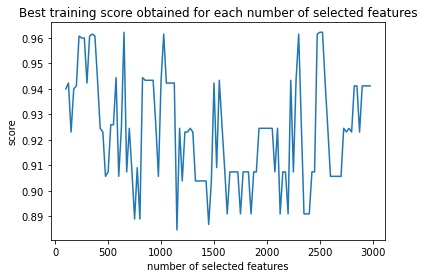

In [11]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, D6_1, FamiliesClusters, compute_precision,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [12]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9622641509433962 0.9137931034482759
0.9607843137254902 0.8793103448275862


In [13]:
MIM_sub = best_subset

In [17]:
get_best_genes_names(MIM_sub, '../data/processed_data/D6_exp1genes_interest.csv', '../data/optimized_subsets/D6_exp1genes_best1.csv')

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [345] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


475 0.9629629629629629


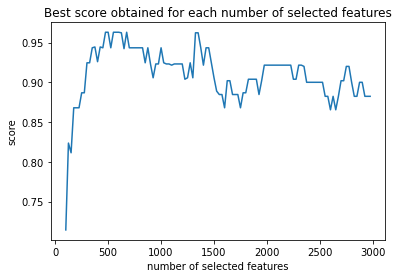

In [18]:
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, D6_1, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [19]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6_1[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

0.9629629629629629 0.9310344827586207
0.9622641509433962 0.9137931034482759


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [345] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


435 0.9629629629629629


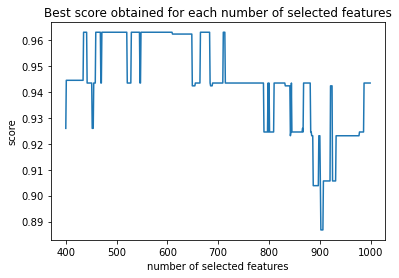

In [26]:
N = np.arange(400,1000,1)
best_subset, best_score = ANOVA(y, D6_1, FamiliesClusters, compute_precision,True, N, plot=True)
print(len(best_subset), best_score)

In [27]:
ANOVA_sub = best_subset

In [28]:
get_best_genes_names(ANOVA_sub, '../data/processed_data/D6_exp1genes_interest.csv', '../data/optimized_subsets/D6_exp1genes_best2.csv')

D6_exp2

In [46]:
D6_df = pyreadr.read_r('../data/family_datasets/data_norm/BIDDY_D6_2_RPM_norm.rds')
D6_df = D6_df[None]

families_interest_D6 = pyreadr.read_r('../data/family_datasets/family_interest/families_of_interest_BIDDY_D6_2.RData')
families_interest_D6 = families_interest_D6['fois_1']

families_info_D6 = pyreadr.read_r('../data/family_datasets/family_info/family_info_BIDDY_D6_2.RData')
families_info_D6 = families_info_D6['family_info_1']

#Conversion into array 
families_interest_D6 = np.array(families_interest_D6)
families_info_D6 = np.array(families_info_D6)

#Remove all genes that are not expressed in at least percentage (default 50%) of the cells
gene_expressed = filter_norm_data(D6_df,0.05)
D6_df = D6_df[gene_expressed]

#Store the name of genes of interest
genes_interest = D6_df.index.values #get name of genes
genes_interest = pd.DataFrame(genes_interest)
genes_interest.to_csv('../data/processed_data/D6_exp2genes_interest.csv', index=False)

#Norm data with only the cells belonging to the family of interest
D6_2 = select_family_interest_norm_data(families_info_D6, families_interest_D6, D6_df)
y = D6_2[1][:,0].astype(np.int32)
D6_2 = np.array(D6_2[0].T)

100 1.0


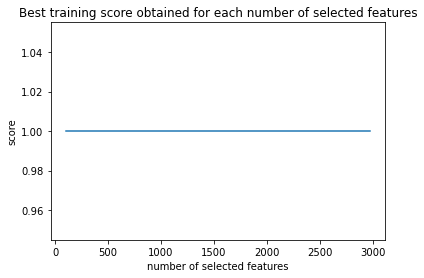

In [48]:
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, D6_2, FamiliesClusters, compute_recovery,True, N, 3, plot=True) 
print(len(best_subset), best_score)

In [49]:
#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6_2[:, best_subset]
pred = model.fit_predict(x_subset,y)
print(model.score_, model.recovery)

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)

model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = x_subset, y= y)
print(model.score_, model.recovery)

1.0 0.8947368421052632
1.0 0.8421052631578947


In [ ]:
MIM_sub = best_subset

In [ ]:
get_best_genes_names(MIM_sub, '../data/processed_data/D6_exp2genes_interest.csv', '../data/optimized_subsets/D6_exp2genes_best1.csv')

# Hybrid methods

# Mutual information and stimulated annealing

In [ ]:
#Define parameters for MI + stimulated annealing method
N = np.array([800])
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_iter': 1400, 'n_neighbors': 3, 'p_mutate': 0.1, 'c': 1, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,D6, FamiliesClusters, compute_precision,True, 10,  MI_stimulated_annealing, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

# Mutual information and genetic feature selection

In [ ]:
#Define parameters for MI + genetic algorithm method
N = np.array([800])                            
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'n_population': 300, 'crossover_proba': 0.5, 'mutation_proba': 0.2, 'n_generations': 120, 'tournament_size': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,D6, FamiliesClusters, compute_precision,True, 30,  MI_genetic_fs, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = D6[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 